# Timeseries anomaly detection using an Autoencoder

## Objective

This script demonstrates how you can use a reconstruction autoencoder model to detect anomalies in timeseries data.


## Setup


In [2]:
import os
# Set the Keras backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

import jax
import keras
import numpy as np
import pandas as pd

from keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

from tqdm.keras import TqdmCallback

np.random.seed(42)

# Print the backend and JAX devices to confirm
print(f'Using Keras backend: {keras.backend.backend()}')
print(f'JAX devices available: {jax.devices()}')

Using Keras backend: jax
JAX devices available: [CpuDevice(id=0)]


## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artifical
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.


In [3]:
df_small_noise = pd.read_csv('../../datasets/art_daily_small_noise.csv')
df_daily_jumpsup = pd.read_csv('../../datasets/art_daily_jumpsup.csv')

## Quick look at the data


In [4]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


## Visualize the data


In [5]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

### Timeseries data without anomalies

We will use the following data for training.


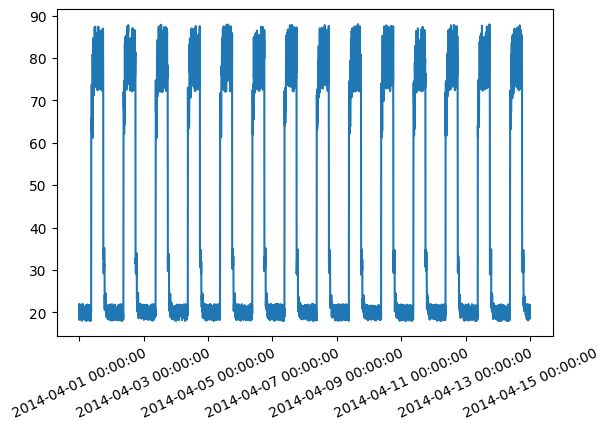

In [6]:
plot_dates_values(df_small_noise)

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.


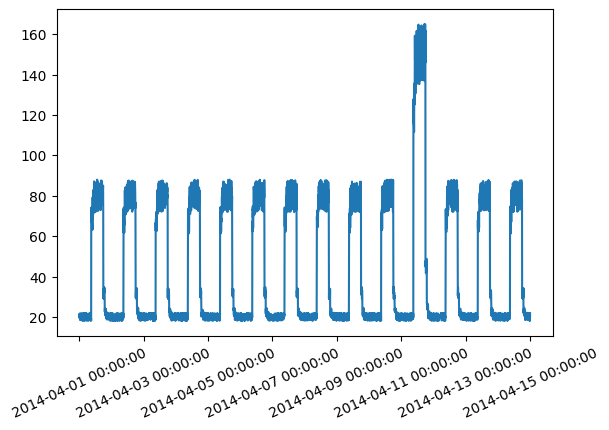

In [7]:
plot_dates_values(df_daily_jumpsup)

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total


In [8]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.


In [9]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)

x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.


In [10]:
n_steps = x_train.shape[1]
n_features = x_train.shape[2]

keras.backend.clear_session()
model = keras.Sequential(
    [
        layers.Input(shape=(n_steps, n_features)),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last', dilation_rate=1, activation="linear"),
        layers.LSTM(units=25, activation="tanh", name="lstm_1", return_sequences=False),
        layers.RepeatVector(n_steps),
        layers.LSTM(units=25, activation="tanh", name="lstm_2", return_sequences=True),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last', dilation_rate=1, activation="linear"),
        layers.TimeDistributed(layers.Dense(1, activation='linear'))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 288, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         5,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 288, 25)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 288, 25)        │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 288, 32)        │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 288, 1)         │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,477 (91.71 KB)

 Trainable params: 23,477 (91.71 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.


In [11]:
history = model.fit(x_train,
x_train, epochs=128, batch_size=512,validation_split=0.2,verbose=0,
callbacks=[TqdmCallback(verbose=1),
keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True)],
)

Epoch 1/100
6/6 - 41s - 7s/step - loss: 1.0029 - val_loss: 1.0030
Epoch 2/100
6/6 - 13s - 2s/step - loss: 0.9977 - val_loss: 0.9974
Epoch 3/100
6/6 - 4s - 593ms/step - loss: 0.9936 - val_loss: 0.9916
Epoch 4/100
6/6 - 3s - 583ms/step - loss: 0.9856 - val_loss: 0.9781
Epoch 5/100
6/6 - 3s - 573ms/step - loss: 0.9689 - val_loss: 0.9549
Epoch 6/100
6/6 - 3s - 581ms/step - loss: 0.9509 - val_loss: 0.9430
Epoch 7/100
6/6 - 3s - 560ms/step - loss: 0.9403 - val_loss: 0.9239
Epoch 8/100
6/6 - 3s - 554ms/step - loss: 0.9282 - val_loss: 0.9169
Epoch 9/100
6/6 - 3s - 568ms/step - loss: 0.9185 - val_loss: 0.9062
Epoch 10/100
6/6 - 3s - 575ms/step - loss: 0.9101 - val_loss: 0.8968
Epoch 11/100
6/6 - 3s - 557ms/step - loss: 0.9019 - val_loss: 0.8879
Epoch 12/100
6/6 - 3s - 573ms/step - loss: 0.8932 - val_loss: 0.8771
Epoch 13/100
6/6 - 3s - 565ms/step - loss: 0.9124 - val_loss: 0.8952
Epoch 14/100
6/6 - 3s - 548ms/step - loss: 0.9038 - val_loss: 0.8875
Epoch 15/100
6/6 - 3s - 568ms/step - loss: 0.88

Let's plot training and validation loss to see how the training went.


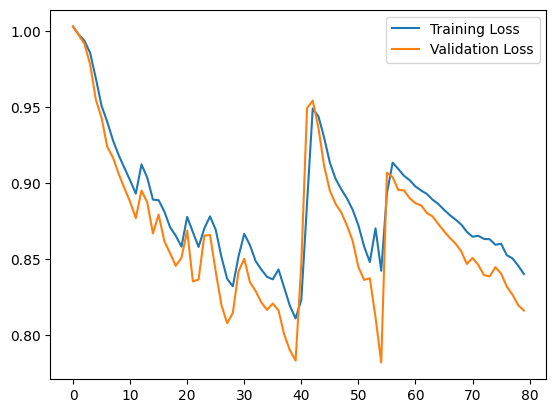

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.



117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step


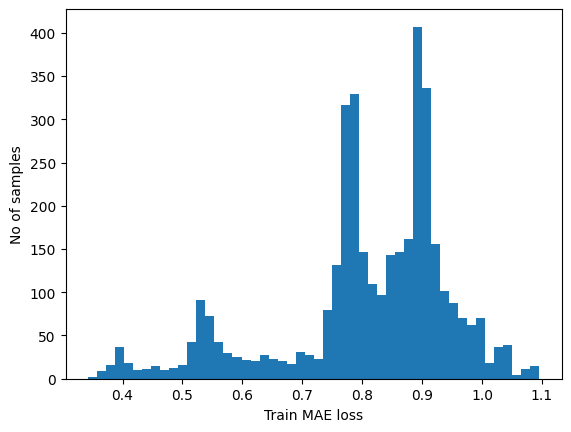

Reconstruction error threshold:  1.0953093802579004


In [13]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.


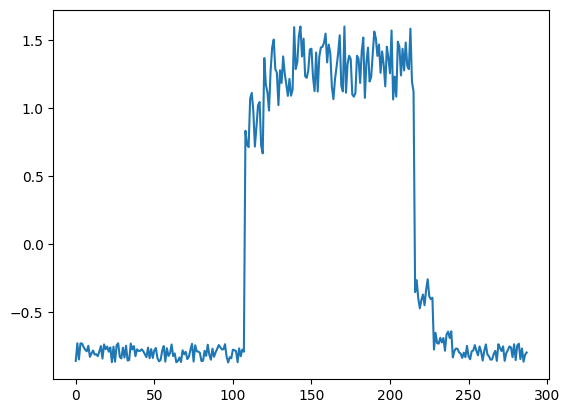

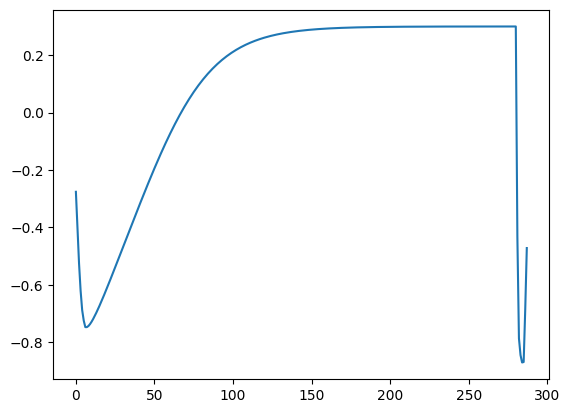

In [14]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data


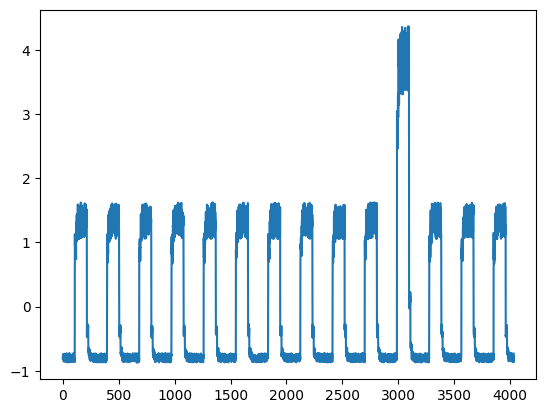

Test input shape:  (3744, 288, 1)
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


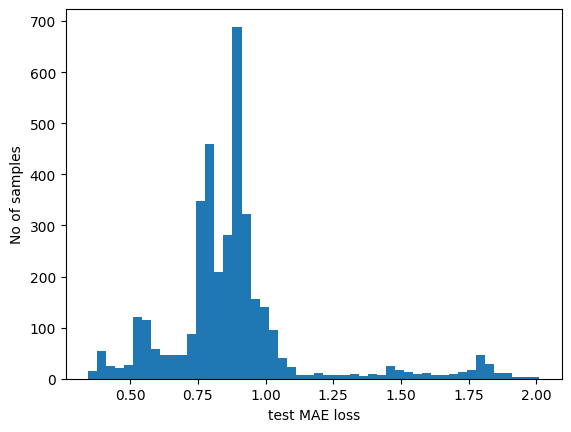

Number of anomaly samples:  322
Indices of anomaly samples:  (array([2522, 2738, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
       2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847,
       2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858,
       2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869,
       2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2

In [15]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.


In [16]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

print(anomalous_data_indices)

[3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060]


Let's overlay the anomalies on the original test data plot.


[143.257886337, 141.375691476, 162.558258037, 151.940306437, 137.949131962, 140.595854562, 164.736030621, 140.67293255299998, 153.101669559, 147.562906904, 161.523164661, 157.611334766, 152.86613525200002, 135.284640106, 161.349096329, 148.298884492, 162.902138864, 149.824607501, 155.783518728, 137.040762969, 157.310909944, 145.131830514, 145.532697769, 138.551989898, 139.397982089, 140.56497458299998, 144.838150922, 161.750125145, 146.039706362, 156.722187857, 137.474799425, 152.72449239, 149.448447071, 164.336915344]


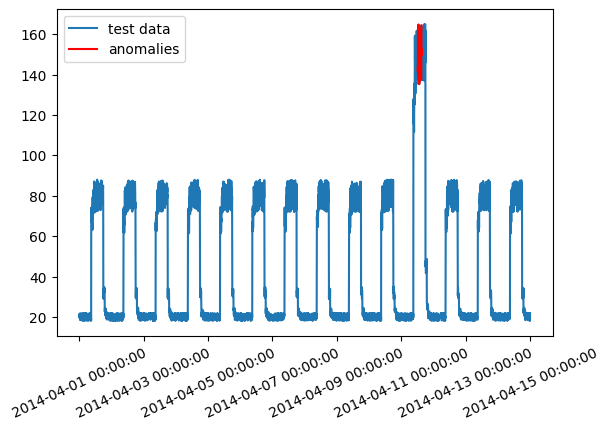

In [17]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()

print(f'{values}')

plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()